In [24]:
# load the diabetes dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr


In [10]:
df = pd.read_csv('diabetic_data.csv')
df.head()


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [11]:
df.shape

(101766, 50)

In [13]:
# Basic missing value summary
df.replace("?", np.nan, inplace=True)

missing_summary = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_summary / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_summary,
    'Percent Missing': missing_percent
})

# Filter only columns with missing values
missing_df = missing_df[missing_df['Missing Values'] > 0]

missing_df

,Missing Values,Percent Missing
weight,98569,96.858479
max_glu_serum,96420,94.746772
A1Cresult,84748,83.277322
medical_specialty,49949,49.082208
payer_code,40256,39.557416
race,2273,2.233555
diag_3,1423,1.398306
diag_2,358,0.351787
diag_1,21,0.020636


In [25]:
# Drop 'weight' due to excessive missingness
df.drop(columns=['weight'], inplace=True)


KeyError: "['weight'] not found in axis"

In [16]:
# Impute 'medical_specialty' and 'race' with placeholder
df['medical_specialty'] = df['medical_specialty'].fillna('Unknown')
df['race'] = df['race'].fillna('Unknown')

In [17]:
df.drop(columns=['payer_code'], inplace=True)  
# Fill diagnosis codes with placeholder
for col in ['diag_1', 'diag_2', 'diag_3']:
    df[col] = df[col].fillna('Missing')

In [18]:
# 'max_glu_serum' and 'A1Cresult' — treat 'None' as a valid category (don’t impute)
# binary flags to indicate tests were taken because that can impact readmissioms
df['max_glu_serum_test_taken'] = (df['max_glu_serum'] != 'None').astype(int)
df['A1Cresult_test_taken'] = (df['A1Cresult'] != 'None').astype(int)

Understanding Target Variable (Readmission within 30 days)

readmitted
NO     53.911916
>30    34.928169
<30    11.159916
Name: proportion, dtype: float64


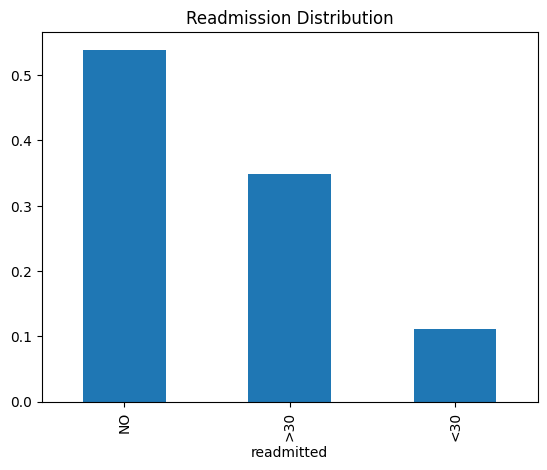

In [19]:
df['readmitted'].value_counts(normalize=True).plot(kind='bar', title="Readmission Distribution")
print(df['readmitted'].value_counts(normalize=True) * 100)



The dataset is unbalanced. Readmissions within 30 days is around ~11% of the total number of patients.

In [23]:
# Lets do binary classificatiion as most interested in 30 day readmission
df['readmit_30'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
print(df['readmit_30'].value_counts(normalize=True) * 100)

readmit_30
0    88.840084
1    11.159916
Name: proportion, dtype: float64


Analysis of numerical variables

In [26]:
from scipy.stats import pointbiserialr

numeric_cols = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses'
]

for col in numeric_cols:
    corr, pval = pointbiserialr(df[col], df['readmit_30'])
    print(f"{col}: correlation = {corr:.3f}, p-value = {pval:.3e}")

time_in_hospital: correlation = 0.044, p-value = 3.455e-45
num_lab_procedures: correlation = 0.020, p-value = 8.208e-11
num_procedures: correlation = -0.012, p-value = 9.596e-05
num_medications: correlation = 0.038, p-value = 1.406e-34
number_outpatient: correlation = 0.019, p-value = 1.664e-09
number_emergency: correlation = 0.061, p-value = 8.295e-84
number_inpatient: correlation = 0.165, p-value = 0.000e+00
number_diagnoses: correlation = 0.050, p-value = 2.735e-56


Most corelation with number_inpatient, followed by number_emergency, number_diagnoses,time_in_hospital and num_medications

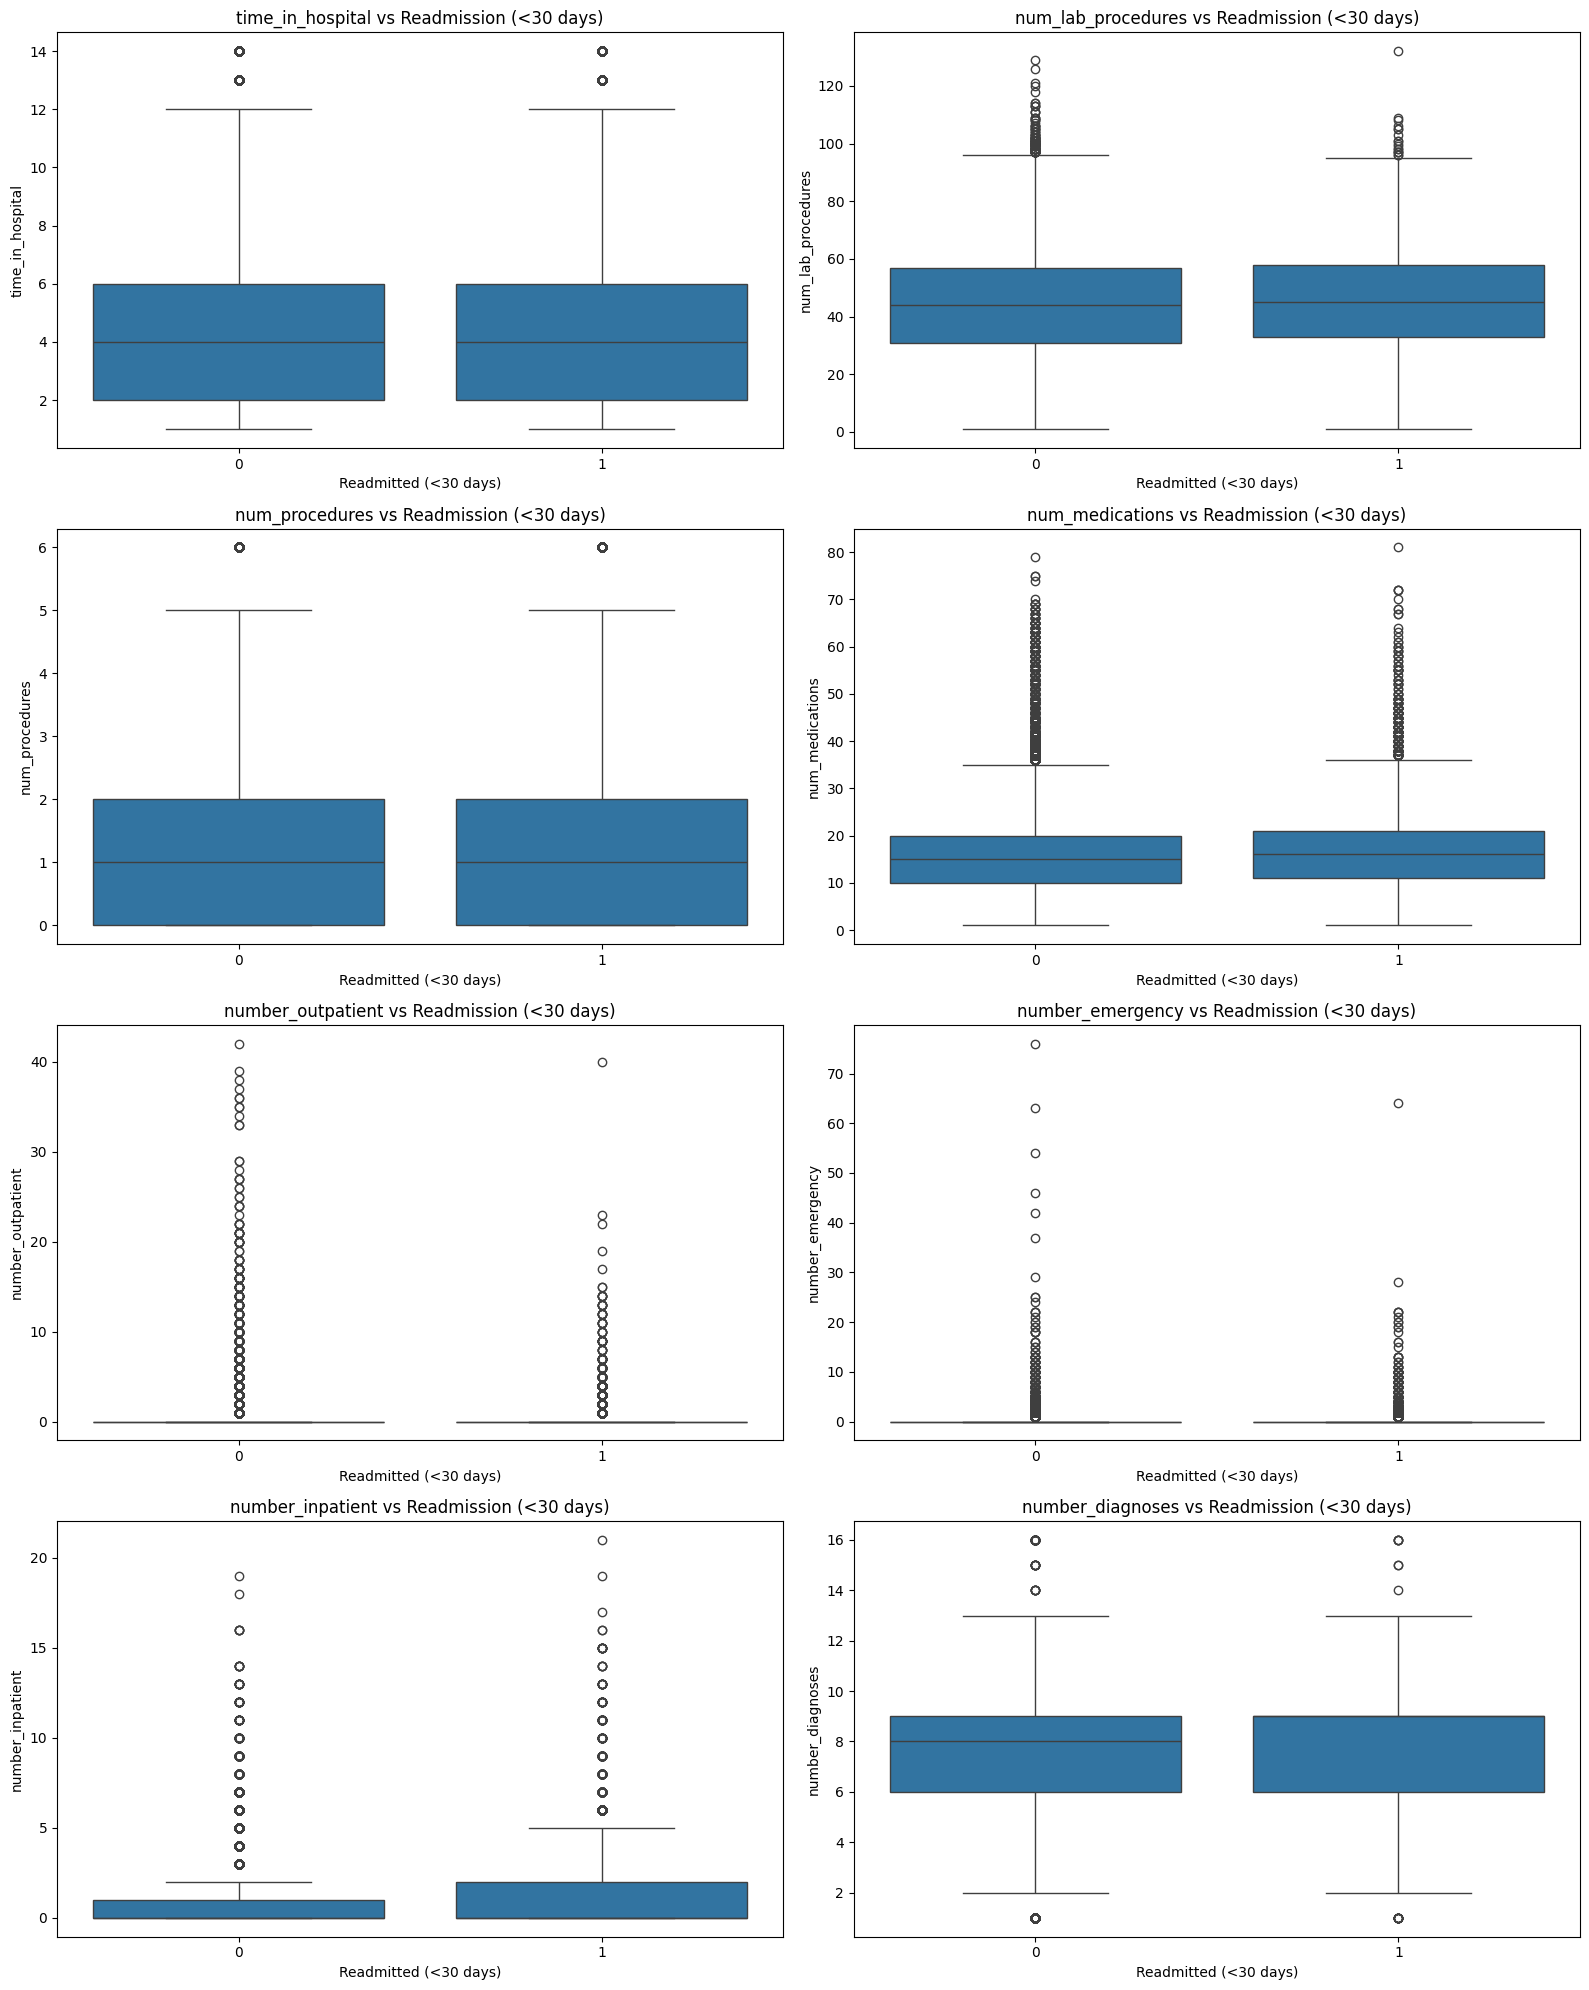

In [27]:
# look at distributions
import matplotlib.pyplot as plt
import seaborn as sns

numerical_features = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses'
]

plt.figure(figsize=(16, 20))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(x='readmit_30', y=col, data=df)
    plt.title(f'{col} vs Readmission (<30 days)')
    plt.xlabel("Readmitted (<30 days)")
    plt.ylabel(col)
plt.tight_layout()
plt.show()

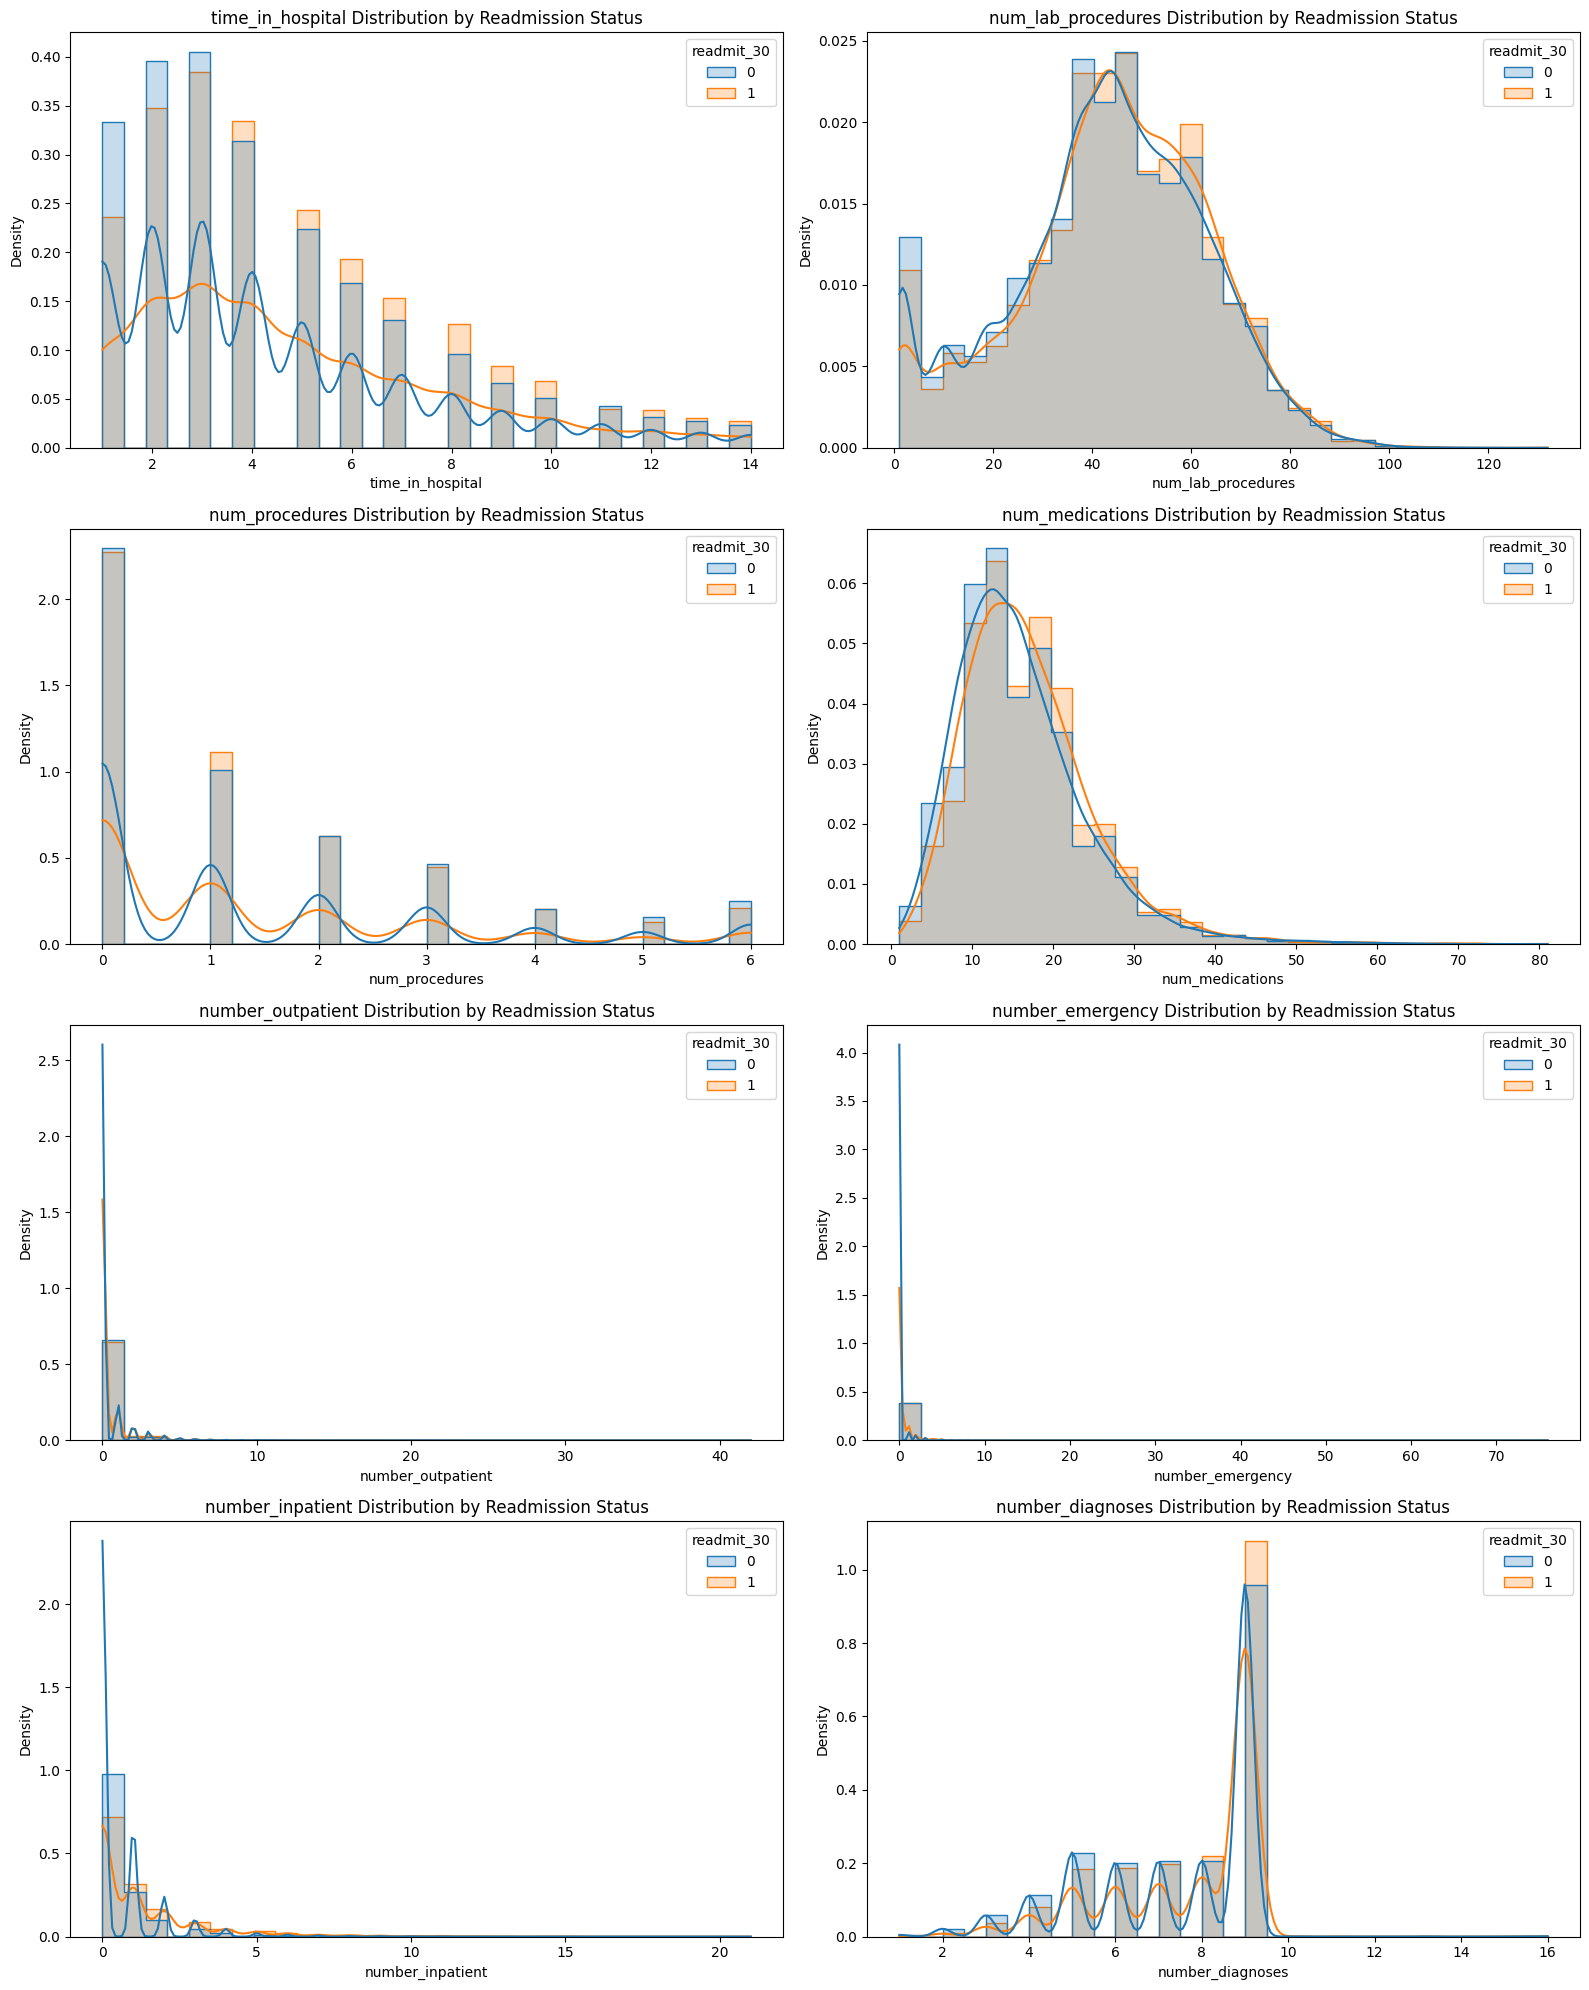

In [29]:
plt.figure(figsize=(16, 20))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(4, 2, i)
    sns.histplot(data=df, x=col, hue='readmit_30', kde=True, stat="density", 
                 common_norm=False, element="step", bins=30)
    plt.title(f'{col} Distribution by Readmission Status')
plt.tight_layout()
plt.show()

Understand categorical features

In [34]:
admission_type_map = {
    1: "Emergency",
    2: "Urgent",
    3: "Elective",
    4: "Newborn",
    5: "Not Available",
    6: "NULL",
    7: "Trauma Center",
    8: "Not Mapped"
}

df['admission_type'] = df['admission_type_id'].map(admission_type_map)

In [ ]:
discharge_disposition_map = {
    1: "Discharged to home",
    2: "To short term hospital",
    3: "To SNF",
    4: "To ICF",
    5: "To other inpatient care",
    6: "Home w/ health service",
    7: "Left AMA",
    8: "Home under IV provider",
    9: "Admitted inpatient to hospital",
    10: "Neonate to another hospital",
    11: "Expired",
    12: "Still patient",
    13: "Hospice / home",
    14: "Hospice / facility",
    15: "To Medicare swing bed",
    16: "To outpatient (other inst.)",
    17: "To outpatient (this inst.)",
    18: "NULL",
    19: "Expired at home (Medicaid)",
    20: "Expired in facility (Medicaid)",
    21: "Expired, unknown place",
    22: "To rehab facility",
    23: "To long-term care hospital",
    24: "To Medicaid-only nursing",
    25: "Not Mapped",
    26: "Unknown/Invalid",
    27: "To federal facility",
    28: "To psychiatric hospital",
    29: "To Critical Access Hospital"
}



df['discharge_disposition'] = df['discharge_disposition_id'].map(discharge_disposition_map)

In [45]:
# Admission Type Mapping
admission_source_map = {
    1: 'Physician Referral',
    2: 'Clinic Referral',
    3: 'HMO Referral',
    4: 'Transfer from hospital',
    5: 'Transfer from SNF',
    6: 'Transfer from other healthcare',
    7: 'Emergency Room',
    8: 'Court/Law Enforcement',
    9: 'Not Available',
    10: 'Transfer from critical access hospital',
    11: 'Normal Delivery',
    12: 'Premature Delivery',
    13: 'Sick Baby',
    14: 'Extramural Birth',
    15: 'Not Available',
    17: 'NULL',
    18: 'Transfer from another Home Health Agency',
    19: 'Readmission to same Home Health Agency',
    20: 'Not Mapped',
    21: 'Unknown/Invalid',
    22: 'Transfer within same facility',
    23: 'Born inside hospital',
    24: 'Born outside hospital',
    25: 'Transfer from Ambulatory Surgery Center',
    26: 'Transfer from Hospice'
}

In [46]:
# Map the admission type to human-readable labels
df['admission_source'] = df['admission_source_id'].map(admission_source_map)

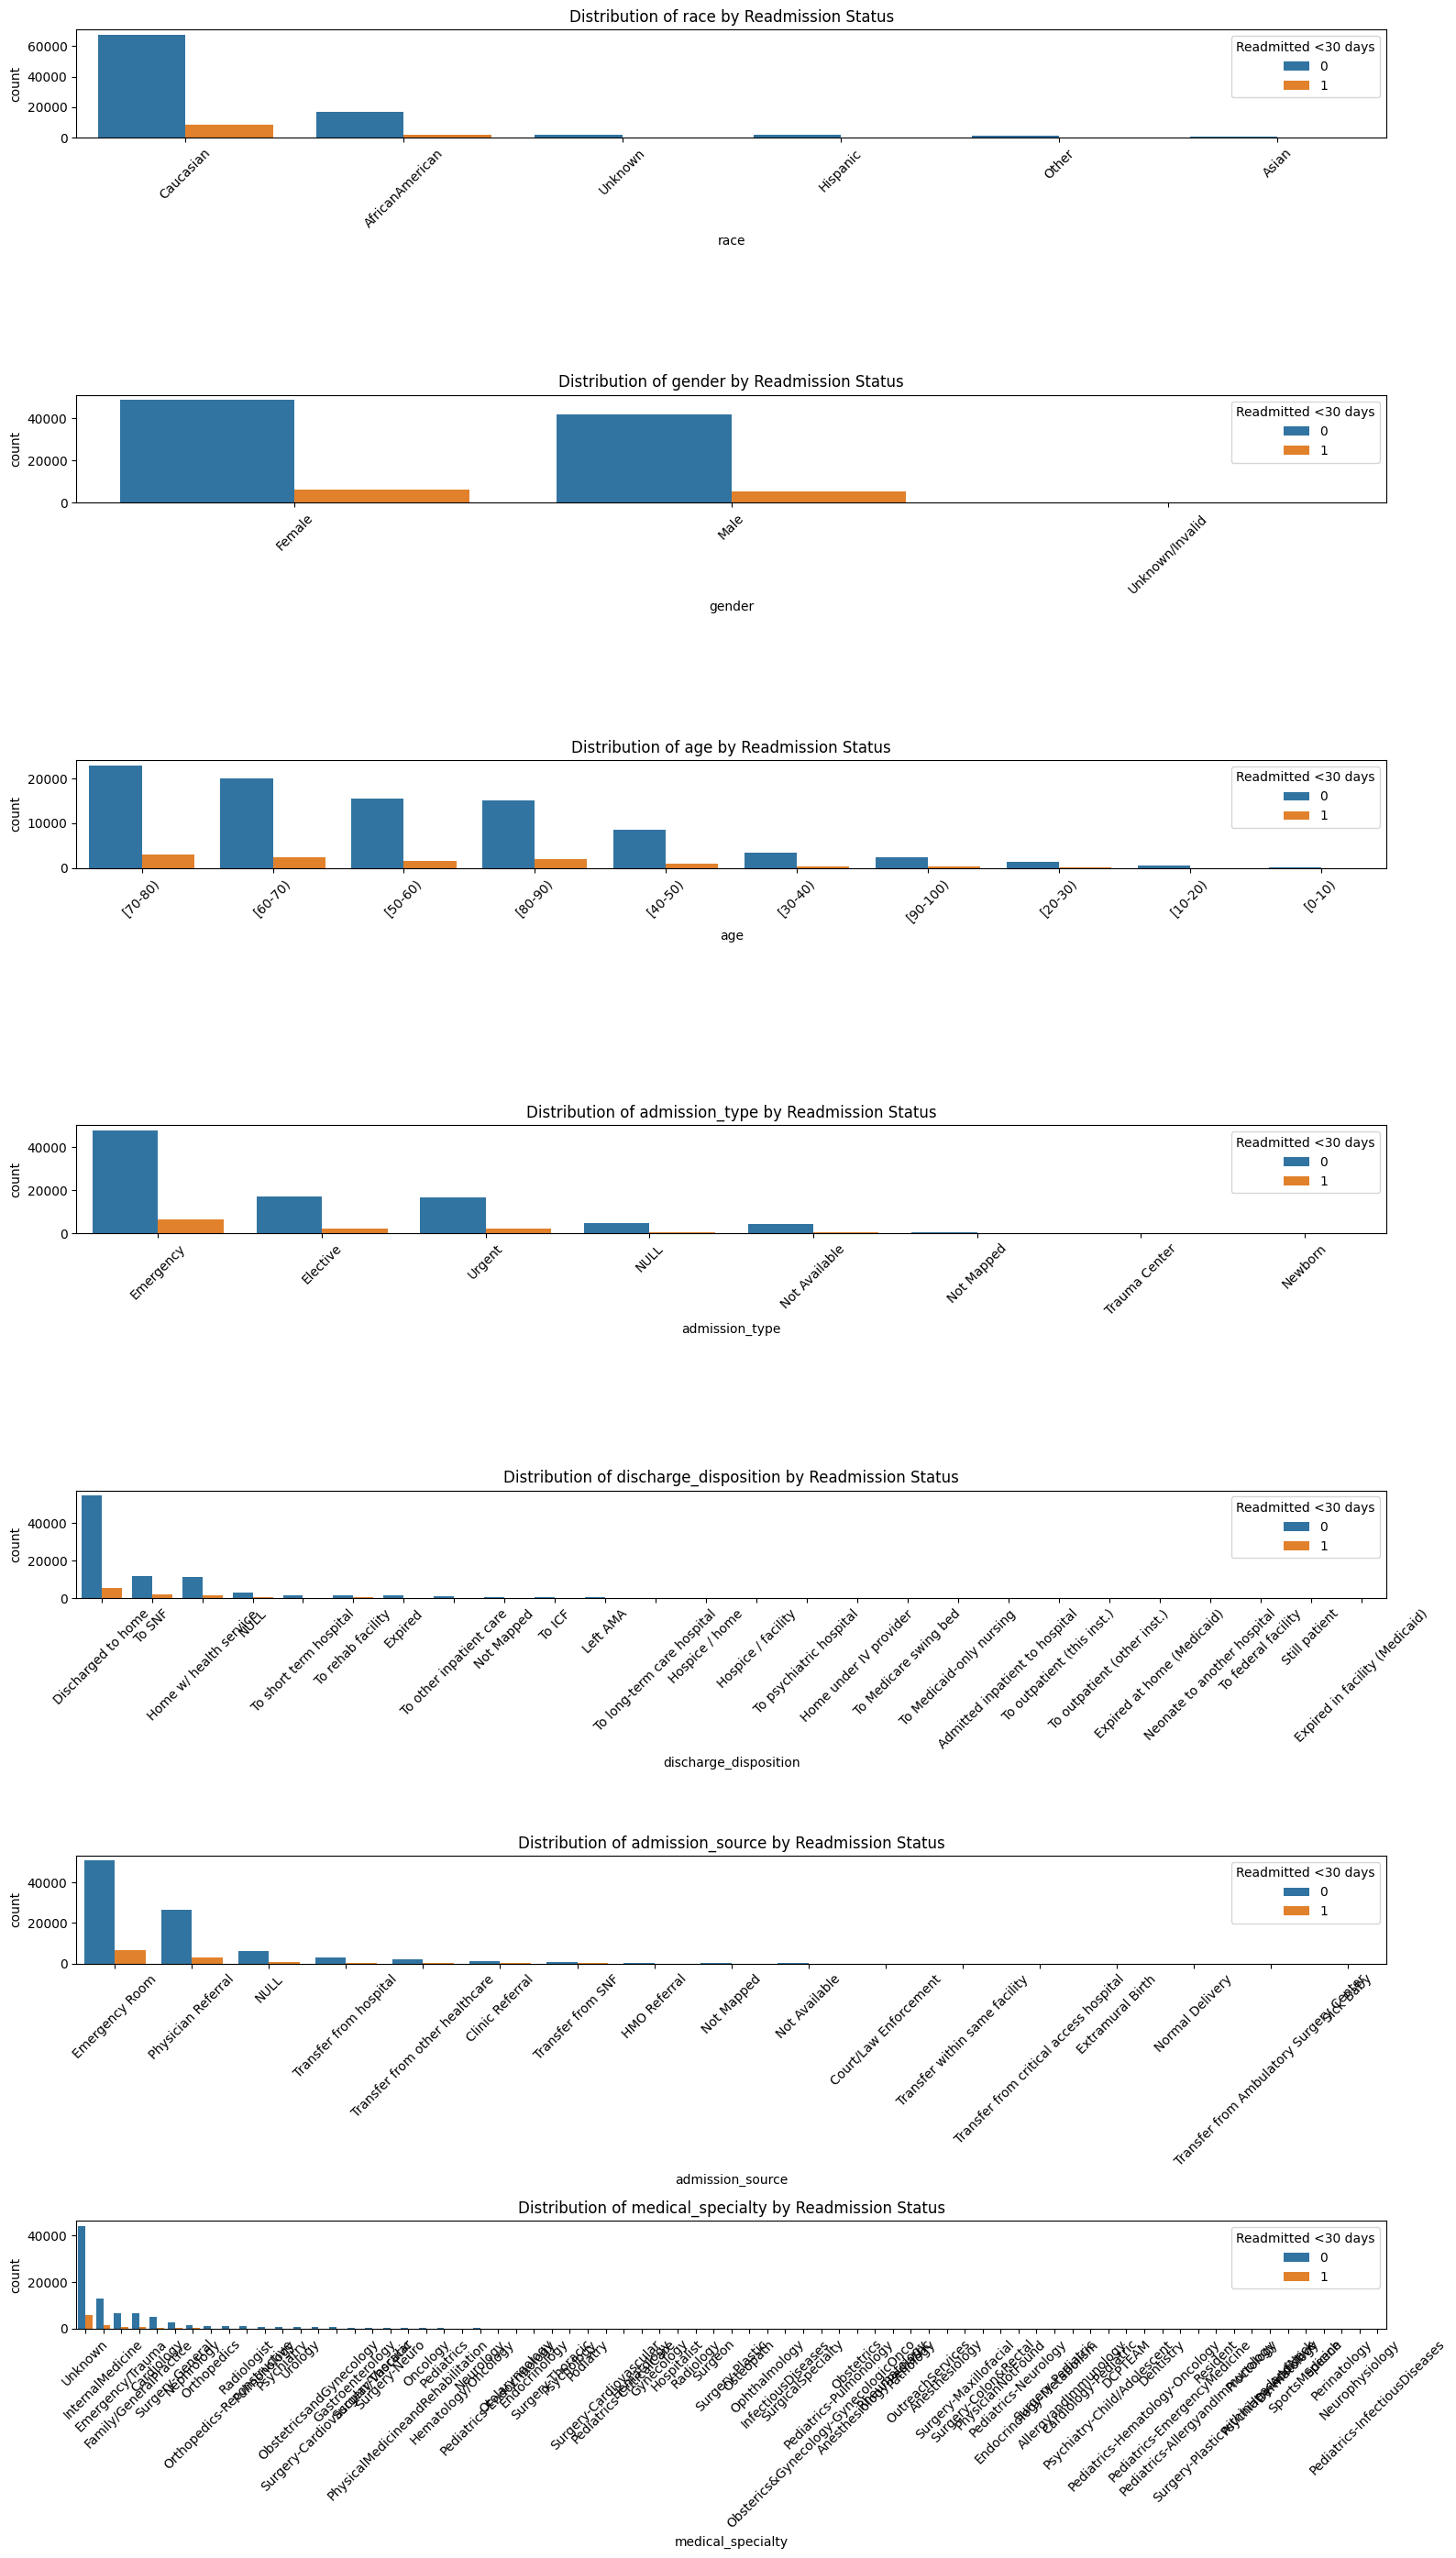

In [47]:
categorical_features = [
    'race', 'gender', 'age', 'admission_type', 'discharge_disposition', 
    'admission_source', 'medical_specialty', 
]

plt.figure(figsize=(16, 4 * len(categorical_features)))

for i, col in enumerate(categorical_features, 1):
    plt.subplot(len(categorical_features), 1, i)
    sns.countplot(data=df, x=col, hue='readmit_30', order=df[col].value_counts().index)
    plt.title(f'Distribution of {col} by Readmission Status')
    plt.xticks(rotation=45)
    plt.legend(title='Readmitted <30 days')
plt.tight_layout()
plt.show()

? Medical speciality has a large distribution, should we do something about this? 


In [33]:
# convert age to numeric for better analysis for ensemble models
age_map = {
    '[0-10)': 5,
    '[10-20)': 15,
    '[20-30)': 25,
    '[30-40)': 35,
    '[40-50)': 45,
    '[50-60)': 55,
    '[60-70)': 65,
    '[70-80)': 75,
    '[80-90)': 85,
    '[90-100)': 95
}

df['age_numeric'] = df['age'].map(age_map)

In [48]:

# referencing the paper https://onlinelibrary.wiley.com/doi/10.1155/2014/781670 , lets group the diagnosis into broader categories
import re
# Define the groups and their ICD code ranges as tuples (start, end)
# For simplicity, codes like 250.xx are treated as 250 to 250.99
# 'E' and 'V' codes handled separately

# We'll convert codes to float for numeric ranges, and handle E, V codes as special.

def icd9_to_group(code):
    if pd.isna(code):
        return 'Unknown'
    code = str(code).strip()
    
    # Handle E and V codes separately
    if code.startswith('E'):
        return 'External causes of injury and supplemental classification'
    if code.startswith('V'):
        return 'External causes of injury and supplemental classification'
    
    # Extract numeric part before decimal
    match = re.match(r'(\d+)(?:\.(\d+))?', code)
    if not match:
        return 'Other/Unknown'
    
    main_code = int(match.group(1))
    # decimal_part = match.group(2) # we might use if needed
    
    # Map ranges from your table:
    if (390 <= main_code <= 459) or main_code == 785:
        return 'Circulatory'
    elif (460 <= main_code <= 519) or main_code == 786:
        return 'Respiratory'
    elif (520 <= main_code <= 579) or main_code == 787:
        return 'Digestive'
    elif main_code == 250:
        return 'Diabetes'
    elif 800 <= main_code <= 999:
        return 'Injury'
    elif 710 <= main_code <= 739:
        return 'Musculoskeletal'
    elif (580 <= main_code <= 629) or main_code == 788:
        return 'Genitourinary'
    elif 140 <= main_code <= 239:
        return 'Neoplasms'
    elif main_code in [780, 781, 784] or (790 <= main_code <= 799):
        return 'Other symptoms, signs, and ill-defined conditions'
    elif (240 <= main_code <= 279) and main_code != 250:
        return 'Endocrine, nutritional, and metabolic diseases (excluding diabetes)'
    elif (680 <= main_code <= 709) or main_code == 782:
        return 'Skin and subcutaneous tissue diseases'
    elif 1 <= main_code <= 139:
        return 'Infectious and parasitic diseases'
    elif 290 <= main_code <= 319:
        return 'Mental disorders'
    elif 280 <= main_code <= 289:
        return 'Blood diseases'
    elif 320 <= main_code <= 359:
        return 'Nervous system diseases'
    elif 630 <= main_code <= 679:
        return 'Pregnancy complications'
    elif 360 <= main_code <= 389:
        return 'Sense organs diseases'
    elif 740 <= main_code <= 759:
        return 'Congenital anomalies'
    else:
        return 'Other/Unknown'

# Apply to your dataframe columns:
for col in ['diag_1', 'diag_2', 'diag_3']:
    df[col + '_group'] = df[col].apply(icd9_to_group)

# Example output check:
print(df[['diag_1', 'diag_1_group', 'diag_2', 'diag_2_group', 'diag_3', 'diag_3_group']].head())

   diag_1                                       diag_1_group   diag_2  \
0  250.83                                           Diabetes  Missing   
1     276  Endocrine, nutritional, and metabolic diseases...   250.01   
2     648                            Pregnancy complications      250   
3       8                  Infectious and parasitic diseases   250.43   
4     197                                          Neoplasms      157   

    diag_2_group   diag_3                                       diag_3_group  
0  Other/Unknown  Missing                                      Other/Unknown  
1       Diabetes      255  Endocrine, nutritional, and metabolic diseases...  
2       Diabetes      V27  External causes of injury and supplemental cla...  
3       Diabetes      403                                        Circulatory  
4      Neoplasms      250                                           Diabetes  


In [51]:
# IDs to exclude : expired, and discharged to hospice as they are not relevant to our analysis and modeling
exclude_discharge_ids = [11, 13, 14, 19, 20, 21]

# Filter dataframe to exclude these discharge types
df_filtered = df[~df['discharge_disposition_id'].isin(exclude_discharge_ids)].copy()

print(f"Rows before filtering: {len(df)}")
print(f"Rows after filtering: {len(df_filtered)}")

Rows before filtering: 101766
Rows after filtering: 99343
